In [37]:
import torch
from captum.attr import IntegratedGradients
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt


In [38]:
#config

print(torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
print(f"Using device: {device}")


2.5.0.dev20240619
Using device: cpu


In [39]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [40]:
test_dir = "../chest_xray/test"


In [41]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [42]:
batch_size = 1


In [43]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [44]:
class PneumoniaScannerModel(torch.nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoniaScannerModel, self).__init__()
        self.base_model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_out_ftrs = self.base_model.fc.out_features
        self.fc = torch.nn.Linear(num_out_ftrs, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = PneumoniaScannerModel().to(device)


In [45]:
model_pickle_path = "../Model/PneumoniaScannerModel_wSampler.pth"


In [46]:
model.load_state_dict(torch.load(model_pickle_path))


<All keys matched successfully>

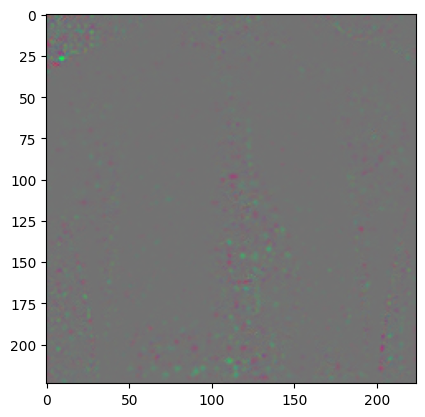

In [47]:

# Assuming your model is already defined and trained
model.eval()

dataiter = iter(test_loader)
batch = next(dataiter)
images, labels = batch

input_tensor = images.to(device)

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Calculate attributions
attributions = ig.attribute(input_tensor, target=0, n_steps=200)

# Visualize attributions
attributions = attributions.squeeze().cpu().detach().numpy()
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())  # Normalize to 0-1
plt.imshow(attributions.transpose(1, 2, 0))
plt.show()
